In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import timm
import random

In [2]:
def seed_everything(seed):
    torch.manual_seed(seed) #torch를 거치는 모든 난수들의 생성순서를 고정한다
    torch.cuda.manual_seed(seed) #cuda를 사용하는 메소드들의 난수시드는 따로 고정해줘야한다 
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True #딥러닝에 특화된 CuDNN의 난수시드도 고정 
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed) #numpy를 사용할 경우 고정
    random.seed(seed) #파이썬 자체 모듈 random 모듈의 시드 고정
seed_everything(5148)

In [3]:
dataset_path = './Rice_Image_Dataset' #데이터 셋 경로 정의
classes = [] # 클래스 이름을 저장할 빈 리스트를 초기화

#데이터셋 경로의 폴더들을 반복하는 데,
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):  # 만약 폴더라면
        classes.append(folder) # 폴더의 이름을 class리스트에 추가


In [4]:
img_sample = [] # 샘플 이미지를 저장할 빈 리스트
# 각 클래스에 대해 반복
for cat in classes:
    folder_path = os.path.join(dataset_path, cat) #폴더 주소를 만들고
    # 각 클래스의 이미지들에 대해
    for img_name in os.listdir(folder_path):
        # 이미지 샘플파일을 통해 이미지를 첫번째 이미지를 보고 루프 종료
        img_path = os.path.join(folder_path, img_name)
        img = Image.open(img_path)
        img_sample.append(img)
        break

In [5]:
# 이미지 경로와 해당하는 라벨을 저장할 빈 리스트를 초기화합니다.
all_images = []
all_labels = []
# 각 클래스에 대해
for label in classes:
    folder = os.path.join(dataset_path, label)
    # 이미지 경로와 라벨을 저장합니다.
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        all_images.append(img_path)
        all_labels.append(label)

In [6]:
# Train : Temp(Test+Validation) = 6: 4로 나누고,
train_images, temp_images, train_labels, temp_labels = train_test_split(
    all_images, all_labels, test_size=0.4, stratify=all_labels, random_state=42
)

# Validation: Test= 5:5로 나누면
val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)
# Train:Validation:Test=6:2:2로 데이터를 분할함

In [7]:
# 사용자 정의 데이터 셋 클래스 정의
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.label_to_int = {label: idx for idx, label in enumerate(sorted(set(labels)))}
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB') # 이미지를 열고 RGB로 변환
        if self.transform:
            image = self.transform(image)
        # Convert the label from string to integer
        label = self.label_to_int[label]
        return image, label


In [8]:
# 데이터 변환을 정의
# 이미지 크기 조절 및 텐서로 변환
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
# Train Validation Test data set 생성
train_dataset = CustomImageDataset(train_images, train_labels, transform=transform)
val_dataset = CustomImageDataset(val_images, val_labels, transform=transform)
test_dataset = CustomImageDataset(test_images, test_labels, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [9]:
# Pytorch의 nn.Module을 상속하여 VGGNet 모델을 정의합니다.
class VGGNet(nn.Module):
    def __init__(self, num_classes=5):  #클래스가 5가지
        super(VGGNet, self).__init__()
        # timm 라이브러리를 사용하여 VGG16 모델을 생성합니다.
        self.vggnet= timm.create_model('vgg16', pretrained=False, num_classes=num_classes)

    def forward(self, x):
        # 정방향 전파(forward pass) 메서드를 정의
        return self.vggnet(x)

In [10]:
# GPU가 이용가능하면 CUDA 디바이스를 사용하도록 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 앞에서 정의한 VGGNet 모델을 생성하고, 이를 지정된 디바이스로 이동
model = VGGNet().to(device)
# 손실 함수로 CrossEntropy Loss를 사용
criterion = nn.CrossEntropyLoss()
# Optimizer와 learning rate를 설정
optimizer = optim.Adam(model.parameters(), lr=0.0003)


In [11]:
num_epochs = 3
line1=[]
line2=[]
line3=[]
line4=[]

In [12]:
# 주어진 epoch 수 만큼 반복합니다.
for epoch in range(num_epochs):
    model.train()  # 모델을 훈련 모드로 설정
    # 훈련 손실 및 정확도를 초기화
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0
    # 훈련 데이터 로더에서 미니 배치를 가져와 학습을 진행
    for batch_idx, (data, target) in enumerate(train_loader):
        # 데이터와 타겟을 지정된 디바이스로 이동
        data, target = data.to(device), target.to(device)
        # 모델의 파라미터 gradient를 초기화
        optimizer.zero_grad()
        # 정방향 전파를 수행
        outputs = model(data)
        # 훈련 손실을 게산
        loss = criterion(outputs, target)
        # 역방향 전파 및 최적화를 수행
        loss.backward()
        optimizer.step()
        # 훈련 손실을 누적
        total_train_loss += loss.item()
        # 훈련 정확도를 계산
        _, predicted = torch.max(outputs.data, 1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()
    # 평균 훈련 손실과 정확도를 계산
    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    # Validation
    model.eval()  # 모델을 평가 모드로 설정
    # 검증 손실 
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0
    # 검증 데이터 로더에서 미니 배치를 가져와 검증 수행
    with torch.no_grad():
        for data, target in val_loader:
            # 데이터와 타겟을 지정된 디바이스로 이동
            data, target = data.to(device), target.to(device)
            # 정방향 전파를 수행
            outputs = model(data)
            # 검증 손실을 계산
            val_loss = criterion(outputs, target)
            # 검증 손실을 누적
            total_val_loss += val_loss.item()
            # 감증 정확도를 계산
            _, predicted = torch.max(outputs.data, 1)
            total_val += target.size(0)
            correct_val += (predicted == target).sum().item()
    # 평균 검증 손실과 정확도를 계산
    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    # 그래프를 위한 train accuracy, loss, validation accuracy, loss를 출력하기 위해 채워넣음
    line1.append(train_accuracy)
    line2.append(val_accuracy)
    line3.append(avg_train_loss)
    line4.append(avg_val_loss)
    # 에폭당 결과 출력
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}%, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}%")


Epoch 1/3, Training Loss: 0.1883, Training Accuracy: 93.1333%, Validation Loss: 0.1477, Validation Accuracy: 95.1933%
Epoch 2/3, Training Loss: 0.0991, Training Accuracy: 96.7489%, Validation Loss: 0.0840, Validation Accuracy: 97.2267%
Epoch 3/3, Training Loss: 0.0770, Training Accuracy: 97.5822%, Validation Loss: 0.0638, Validation Accuracy: 97.8867%


Test Accuracy: 97.9867


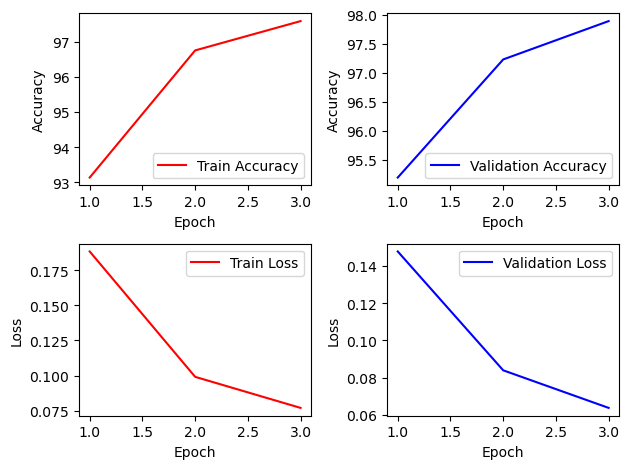

In [13]:
# 테스트 데이터 셋에서 정확도를 계산하기 위한 변수 초기화
correct = 0
total = 0
# 평가 모드로 모델을 설정하고
# 테스트 데이터 셋을 이용하여 정확도 계산
with torch.no_grad():
    model.eval()
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
# 전체 정확도 계산 및 출력
accuracy = correct / total * 100
print(f"Test Accuracy: {accuracy:.4f}")

epoch_numbers=[i+1 for i in range(num_epochs)]
plt.figure()
plt.subplot(2, 2, 1) 
plt.plot(epoch_numbers, line1, label='Train Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(2, 2, 2)  
plt.plot(epoch_numbers, line2, label='Validation Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 3) 
plt.plot(epoch_numbers, line3, label='Train Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.subplot(2, 2, 4)  
plt.plot(epoch_numbers, line4, label='Validation Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()  # 서브플롯간 간격 조절
plt.show()

In [15]:
torch.save(model.state_dict(), 'VGGNet_seed.pt')